```
This software is part of GPU Ocean.

This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016 SINTEF ICT
Copyright (C) 2017-2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

## Notebook description

This notebook is primarly to rapidly test the test simulations.
It can also be used to produce the "correct" results, which are used for comparison in the actual tests.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import datetime
import importlib
import sys


#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import IPythonMagic, PlotHelper, Common

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
## Avoid accidental overwriting the test result!!
# Only use the "timestep50" name unless you need to update some 
# of the tests.
#testdir = 'test-timestep50'

testdir = 'timestep50'


In [4]:
## A common initial condition maker:
def makeCornerBump(eta, nx, ny, dx, dy, halo):
    x_center = 4*dx
    y_center = 4*dy
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] = np.exp(-(x**2/size+y**2/size))

def makeUpperCornerBump(eta, nx, ny, dx, dy, halo):
    x_center = (nx-4)*dx
    y_center = (ny-4)*dy
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] = np.exp(-(x**2/size+y**2/size))

                
def makeCentralBump(eta, nx, ny, dx, dy, halo):
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            #size = (0.015* min(nx, ny)*min(dx, dy))**2
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] = np.exp(-(x**2/size+y**2/size))                
                
def makeLowerLeftBump(eta, nx, ny, dx, dy, halo):
    x_center = dx*nx*0.3
    y_center = dy*ny*0.2
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] = np.exp(-(x**2/size+y**2/size))

# Adding initial conditions on top of existing boundary conditions
def addCornerBump(eta, nx, ny, dx, dy, halo):
    x_center = 4*dx
    y_center = 4*dy
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] += np.exp(-(x**2/size+y**2/size))

def addUpperCornerBump(eta, nx, ny, dx, dy, halo):
    x_center = (nx-4)*dx
    y_center = (ny-4)*dy
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] += np.exp(-(x**2/size+y**2/size))

def addCentralBump(eta, nx, ny, dx, dy, halo):
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)
            #size = (0.015* min(nx, ny)*min(dx, dy))**2
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] += np.exp(-(x**2/size+y**2/size))
                

def makeBottomTopography(Hi, nx, ny, dx, dy, halo, intersections=True):
    extra_cells = 0
    if intersections:
        extra_cells = 1
    for j in range(-halo[2], ny + halo[0] + extra_cells):
        for i in range(-halo[3], nx + halo[1] + extra_cells):
            Hi[j+halo[2], i+halo[3]] = 6 + 2.0*np.cos(0.3*(i + i/(np.sin(0.5*j)+2.5))) + \
                                       2.0*np.sin(2*np.pi*(j+i)/(2.0*ny))
            
            
def saveResults(eta, u, v, method, BC, init, bathymetry=""):
    fileprefix = testdir + "/" + method + "_" + BC + "_" + init + "_" + bathymetry 
    np.savetxt(fileprefix + "eta.dat", eta)
    np.savetxt(fileprefix + "u.dat", u)
    np.savetxt(fileprefix + "v.dat", v)

def loadResults(method, BC, init, bathymetry=""):
    fileprefix = testdir + "/" + method + "_" + BC + "_" + init + "_" + bathymetry
    print ("loading result " + fileprefix)
    eta = np.loadtxt(fileprefix + "eta.dat")
    u =   np.loadtxt(fileprefix + "u.dat")
    v =   np.loadtxt(fileprefix + "v.dat")
    return eta, u, v




In [ ]:
## %%time
# Forward backward linear
nx = 50
ny = 70

dx = 200.0
dy = 200.0

dt = 1
g = 9.81
f = 0.0
beta = 0.0
r = 0.0

simulatorName = "FBL"
# ---------------------------
# Parameters
# ---------------------------
bcSettings = 4
# 1 = closed, 2 = open, 3 = open NS, 4 = open EW, 

#bump = "central"
bump = "upperCorner"
#bump = "corner"

#f = 0.01
#beta = 1e-6
if f > 0.0 or beta > 0.0:
    bump = "central"
    
bathymetry = ""
#bathymetry = "bathymetry_"

# ---------------------------

ghosts = [1,1,1,1]
old_ghosts = None
validDomain = [-1, -1, 1, 1]
if (bcSettings == 1):
    # Closed boundaries
    boundaryConditions = Common.BoundaryConditions()
    old_ghosts = [0,0,0,0] # north, east, south, west
    case = "wallBC"
elif (bcSettings == 2):
    # Periodic boundaries
    boundaryConditions = Common.BoundaryConditions(2,2,2,2)
    old_ghosts = [1,1,0,0]
    case = "periodicAll"
elif bcSettings == 3:
    # Periodic boundaries east-west - and closed boundaries north-south
    boundaryConditions = Common.BoundaryConditions(1,2,1,2)
    old_ghosts = [1,0,0,0] 
    case = "periodicEW"
else:
    # Periodic boundaries north-south - and closed boundaries east-west
    boundaryConditions = Common.BoundaryConditions(2,1,2,1)
    old_ghosts = [0,1,0,0]
    case = "periodicNS"

dataShape = (ny + ghosts[0] + ghosts[2], 
             nx + ghosts[1] + ghosts[2])
    
#h0 = np.ones((ny+ghosts[0], nx+ghosts[1]), dtype=np.float32) * 60;
#eta0 = np.zeros((ny+ghosts[0], nx+ghosts[1]), dtype=np.float32);
#u0 = np.zeros((ny+ghosts[0], nx+1), dtype=np.float32);
#v0 = np.zeros((ny+1, nx+ghosts[1]), dtype=np.float32);

h0 = np.ones(dataShape, dtype=np.float32) * 60;
eta0 = np.zeros(dataShape, dtype=np.float32);
u0 = np.zeros((dataShape[0]  , dataShape[1]-1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]  ), dtype=np.float32, order='C');

# ---------------------------
# Follow up on parameters 
# ---------------------------
if bump == "central":
    case = "wallBC"

# We only have one coriolis case, and have to fix that one's name:
if f > 0.0:
    case = "coriolis"
if beta > 0.0:
    case = "betamodel"
    
if bump == "corner":
    addCornerBump(eta0, nx, ny, dx, dy, ghosts)
elif bump == "upperCorner":
    addUpperCornerBump(eta0, nx, ny, dx, dy, ghosts)
elif bump == "central":
    addCentralBump(eta0, nx, ny, dx, dy, ghosts)
    
if bathymetry == "bathymetry_":
    makeBottomTopography(h0, nx, ny, dx, dy, ghosts, intersections=False)
# ---------------------------    


importlib.reload(Common)
importlib.reload(FBL)

sim = FBL.FBL(gpu_ctx, \
              h0, eta0, u0, v0, \
              nx, ny, \
              dx, dy, dt, \
              g, f, r, coriolis_beta=beta, \
              boundary_conditions=boundaryConditions)

x_center = dx*nx/2.0
y_center = dy*ny/2.0
x_center = 4*dx
y_center = 4*dy
#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


if (ghosts[0] == 0):
    ghosts[0] = None
else:
    ghosts[0] = -ghosts[0]
if (ghosts[1] == 0):
    ghosts[1] = None
else:
    ghosts[1] = -ghosts[1]
fig = plt.figure()
#plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta0, u0, v0)

t = sim.step(50.0)
eta1, u1, v1 = sim.download(interior_domain_only=True)
print ("Data shapes from download:")
print ("eta1.shape: ", eta1.shape)
print ("u1.shape  : ", u1.shape)
print ("v1.shape  : ", v1.shape)
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta1, u1, v1)

#saveResults(eta1, u1, v1, simulatorName, case, bump, bathymetry)
eta2, u2, v2 = loadResults(simulatorName, case, bump, bathymetry)

#print(x_coords.shape)
#print(y_coords.shape)
print ("Data shapes from loadResults")
print ("eta2.shape: ", eta2.shape)
print ("u2.shape  : ", u2.shape)
print ("v2.shape  : ", v2.shape)
print(np.linalg.norm(eta1 - eta2))
print(np.linalg.norm(u1 - u2))
print(np.linalg.norm(v1 - v2))


fig = plt.figure()
#plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta2-eta1, (u2-u1), v2-v2)
#plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta2, u2, v2)


In [ ]:
#Centered in time, centered in space

nx = 50
ny = 70

dx = 200.0
dy = 200.0

dt = 1
g = 9.81
f = 0.0
r = 0.0
beta = 0.0
A = 1

h0 = np.ones((ny+2, nx+2), dtype=np.float32, order='C') * 60;
eta0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
u0 = np.zeros((ny+2, nx+3), dtype=np.float32, order='C');
v0 = np.zeros((ny+3, nx+2), dtype=np.float32, order='C');


#Create bump in center of domain for testing
x_center = dx*nx/2.0
y_center = dy*ny/2.0

simulatorName = "CTCS"
# ---------------------------
# Parameters
# ---------------------------
bcSettings = 2

#bump = "central"
#bump = "upperCorner"
#bump = "corner"

#f = 0.01
#beta = 1e-6
if f > 0.0 or beta > 0.0:
    bump = "central"
    
bathymetry = ""
#bathymetry = "bathymetry_"

# ---------------------------

ghosts = [1,1,1,1]
if (bcSettings == 1):
    boundaryConditions = Common.BoundaryConditions()
    case = "wallBC"
elif (bcSettings == 2):
    boundaryConditions = Common.BoundaryConditions(2,2,2,2)
    case = "periodic"
elif bcSettings == 3:
    boundaryConditions = Common.BoundaryConditions(2,1,2,1) # Periodic NS
    case = "periodicNS"
else:
    boundaryConditions = Common.BoundaryConditions(1,2,1,2) # Periodic EW
    case = "periodicEW"

# ---------------------------
# Follow up on parameters 
# ---------------------------
if bump == "central":
    case = "wallBC"

# We only have one coriolis case, and have to fix that one's name:
if f > 0.0:
    case = "coriolis"
if beta > 0.0:
    case = 'betamodel'

    
if bump == "corner":
    addCornerBump(eta0, nx, ny, dx, dy, ghosts)
elif bump == "upperCorner":
    addUpperCornerBump(eta0, nx, ny, dx, dy, ghosts)
elif bump == "central":
    addCentralBump(eta0, nx, ny, dx, dy, ghosts)
    
if bathymetry == "bathymetry_":
    makeBottomTopography(h0, nx, ny, dx, dy, ghosts, intersections=False)
    

# ---------------------------
    

#Initialize simulator
importlib.reload(CTCS)
sim = CTCS.CTCS(gpu_ctx, \
                h0, eta0, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, A, coriolis_beta=beta,
                boundary_conditions=boundaryConditions)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta0[1:-1, 1:-1], u0[1:-1, :], v0[:, 1:-1])

t = sim.step(50.0)
eta1, u1, v1 = sim.download()
plotter.plot(eta1[1:-1, 1:-1], u1[1:-1, :], v1[:, 1:-1])

#saveResults(eta1, u1, v1, simulatorName, case, bump, bathymetry)
eta2, u2, v2 = loadResults(simulatorName, case, bump, bathymetry)


print("norm diff eta: ", np.linalg.norm(eta1 - eta2))
print("norm diff hu:  ",np.linalg.norm(u1-u2))
print("norm diff hv:  ",np.linalg.norm(v1-v2))
diff_eta = eta1 - eta2
diff_u = u1-u2
diff_v = v1-v2

factor = 10
fig = plt.figure()
plotter2 = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
                               factor*diff_eta[1:-1,1:-1], factor*diff_u[1:-1, :], factor*diff_v[:,1:-1])
#plotter2.plot(diff_eta[1:-1,1:-1], diff_u[1:-1, :], diff_v[:,1:-1])

In [ ]:
# Kurganov-Petrova 2007 paper
reload(KP07)

nx = 50
ny = 70

dx = 200.0
dy = 200.0

dt = 0.95
g = 9.81

f = 0.0
r = 0.0


simulatorName = "KP07"
# ---------------------------
# Parameters
# ---------------------------
bcSettings = 1

bump = "central"
#bump = "upperCorner"
#bump = "corner"

#f = 0.01
if f > 0.0:
    bump = "central"
# ---------------------------

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = ghosts
refRange = [-2, -2, 2, 2]
dataRange = refRange
if (bcSettings == 1):
    boundaryConditions = Common.BoundaryConditions()
    case = "wallBC"
elif (bcSettings == 2):
    boundaryConditions = Common.BoundaryConditions(2,2,2,2)
    case = "periodic"
elif bcSettings == 3:
    # Periodic NS
    boundaryConditions = Common.BoundaryConditions(2,1,2,1)
    case = "periodicNS"
else:
    # Periodic EW
    boundaryConditions = Common.BoundaryConditions(1,2,1,2)
    case = "periodicEW"

dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
    
extraBottom = 0.0
waterHeight = 60 + extraBottom
eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

#Bathymetry:
Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*waterHeight

# ---------------------------
# Follow up on parameters 
# ---------------------------
if bump == "central":
    case = "wallBC"

# We only have one coriolis case, and have to fix that one's name:
if f > 0.0:
    case = "coriolis"
    
if bump == "corner":
    addCornerBump(eta0, nx, ny, dx, dy, validDomain)
elif bump == "upperCorner":
    addUpperCornerBump(eta0, nx, ny, dx, dy, validDomain)
elif bump == "central":
    addCentralBump(eta0, nx, ny, dx, dy, validDomain)
# ---------------------------
    
#Initialize simulator
importlib.reload(KP07)
importlib.reload(Common)
sim = KP07.KP07(gpu_ctx, \
                eta0, Hi, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, \
                boundary_conditions=boundaryConditions)


#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
                                eta0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                                u0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                                v0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])
 
t = sim.step(50.0)
eta1, u1, v1 = sim.download()
plotter.plot(eta1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]],
             u1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]],
             v1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])

#saveResults(eta1, u1, v1, simulatorName, case, bump)
eta2, u2, v2 = loadResults(simulatorName, case, bump)

etaDiff = eta1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]] - eta2[refRange[2]:refRange[0], refRange[3]:refRange[1]]
uDiff = u1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-u2[refRange[2]:refRange[0], refRange[3]:refRange[1]]
vDiff = v1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-v2[refRange[2]:refRange[0], refRange[3]:refRange[1]]

print(np.linalg.norm(eta1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]] -
                     eta2[refRange[2]:refRange[0], refRange[3]:refRange[1]]))
print(np.linalg.norm(u1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-u2[refRange[2]:refRange[0], refRange[3]:refRange[1]]))
print(np.linalg.norm(v1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-v2[refRange[2]:refRange[0], refRange[3]:refRange[1]]))

brighten = 10000
#brighten = 1
#plotter.plot(brighten*etaDiff, brighten*uDiff, brighten*vDiff)

print("np.max(eta1)", np.max(eta1))
print("np.max(etaDiff)", np.max(etaDiff))
print("np.max(uDiff)", np.max(uDiff))
print("np.max(vDiff)", np.max(vDiff))

print "refRange ", refRange
print "dataRange", dataRange

loading result timestep50/CDKLM16_periodicEW_corner_
sim sizes:  (74, 54) (74, 54) (74, 54)
ref sizes:  (74, 54) (74, 54) (74, 54)
eta1 with dataRange:  (70, 50)
eta2 with refRange :  (70, 50)
refRange:  [-2, -2, 2, 2]
dataRange:  [-2, -2, 2, 2]
0.0
0.0
0.0
Plotting diffs
np.max(eta1) 0.17025307
np.max(etaDiff) 0.0
np.max(uDiff) 0.0
np.max(vDiff) 0.0


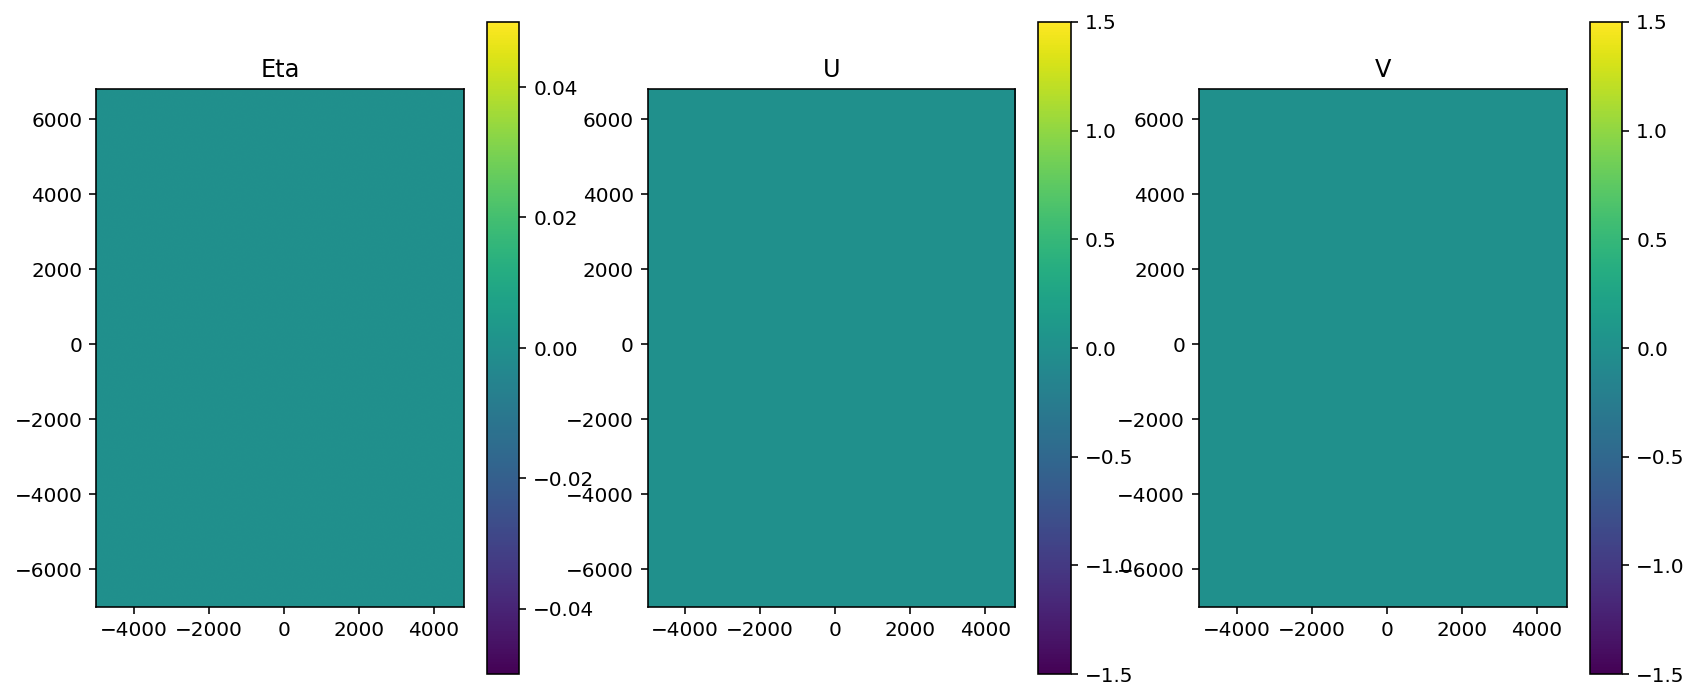

In [22]:
#Coriolis well balanced reconstruction scheme

if 'sim' in globals():
    sim.cleanUp()
    
nx = 50
ny = 70
            

dx = 200.0
dy = 200.0

dt = 0.9
g = 9.81

f = 0.0
beta = 0.0
r = 0.0

simulatorName = "CDKLM16"
# ---------------------------
# Parameters
# ---------------------------
bcSettings = 1

bump = "central"
#bump = "upperCorner"
#bump = "corner"

#beta = 1e-6
#f = 0.01 + 2*beta*dy
if f > 0.0 or beta > 0.0:
    bump = "central"
# ---------------------------

bathymetry = ""
#bathymetry = "bathymetry_"


ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = ghosts
dataRange = [-2, -2, 2, 2]
refRange = [-2, -2, 2, 2]
case = ""
if (bcSettings == 1):
    boundaryConditions = Common.BoundaryConditions()
    case = "wallBC"
elif (bcSettings == 2):
    boundaryConditions = Common.BoundaryConditions(2,2,2,2)
    case = "periodic"
elif bcSettings == 3:
    # Periodic NS
    boundaryConditions = Common.BoundaryConditions(2,1,2,1)
    case = "periodicNS"
else:
    # Periodic EW
    boundaryConditions = Common.BoundaryConditions(1,2,1,2)
    case = "periodicEW"


    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
    
waterHeight = 60
eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
u0   = np.zeros(dataShape, dtype=np.float32, order='C');
v0   = np.zeros(dataShape, dtype=np.float32, order='C');
Hi   = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*waterHeight

             

if bathymetry == "bathymetry_":
    makeBottomTopography(Hi, nx, ny, dx, dy, validDomain)
    
    
#fig = plt.figure(figsize=(4,4))
#plt.imshow(Hi, origin="lower")
#plt.colorbar()
    
# ---------------------------
# Follow up on parameters 
# ---------------------------
if bump == "central":
    case = "wallBC"

# We only have one coriolis case, and have to fix that one's name:
if f > 0.0:
    case = "coriolis"
if beta > 0.0:
    case = "betamodel"
    
if bump == "corner":
    addCornerBump(eta0, nx, ny, dx, dy, validDomain)
elif bump == "upperCorner":
    addUpperCornerBump(eta0, nx, ny, dx, dy, validDomain)
elif bump == "central":
    addCentralBump(eta0, nx, ny, dx, dy, validDomain)
# ---------------------------


#Initialize simulator
importlib.reload(CDKLM16)
importlib.reload(Common)
sim = CDKLM16.CDKLM16(gpu_ctx, \
                eta0, u0, v0, Hi, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, coriolis_beta=beta, \
                boundary_conditions=boundaryConditions)


#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
                                eta0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                                  u0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                                  v0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]],
                                plotRadial=False)
 
#t = sim.step(70.0)
t = sim.step(50.0)
eta1, u1, v1 = sim.download()
plotter.plot(eta1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]],
             u1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]],
             v1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])



#saveResults(eta1, u1, v1, simulatorName, case, bump, bathymetry)
eta2, u2, v2 = loadResults(simulatorName, case, bump, bathymetry)
#eta2, u2, v2 = loadResults(simulatorName, "coriolis", bump, bathymetry)


print ("sim sizes: ", eta1.shape, u1.shape, v1.shape)
print ("ref sizes: ", eta2.shape, u2.shape, v2.shape)
print ("eta1 with dataRange: ", eta1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]].shape)
print ("eta2 with refRange : ", eta2[refRange[2]:refRange[0], refRange[3]:refRange[1]].shape)
print ("refRange: ", refRange)
print ("dataRange: ", dataRange)


etaDiff = eta1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]] - eta2[refRange[2]:refRange[0], refRange[3]:refRange[1]]
uDiff = u1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-u2[refRange[2]:refRange[0], refRange[3]:refRange[1]]
vDiff = v1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-v2[refRange[2]:refRange[0], refRange[3]:refRange[1]]

print(np.linalg.norm(eta1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]] -
                     eta2[refRange[2]:refRange[0], refRange[3]:refRange[1]]))
print(np.linalg.norm(u1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-u2[refRange[2]:refRange[0], refRange[3]:refRange[1]]))
print(np.linalg.norm(v1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]]-v2[refRange[2]:refRange[0], refRange[3]:refRange[1]]))

brighten = 10
if True:
    print('Plotting diffs')
    plotter.plot(brighten*etaDiff, brighten*uDiff, brighten*vDiff)
    #plotter.plot(eta2[refRange[2]:refRange[0], refRange[3]:refRange[1]],
    #            u2[refRange[2]:refRange[0], refRange[3]:refRange[1]],
    #            v2[refRange[2]:refRange[0], refRange[3]:refRange[1]])
    #plotter.plot(eta1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]],
    #            u1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]],
    #            v1[dataRange[2]:dataRange[0], dataRange[3]:dataRange[1]])
print("np.max(eta1)", np.max(eta1))
print("np.max(etaDiff)", np.max(np.abs(etaDiff)))
print("np.max(uDiff)", np.max(np.abs(uDiff)))
print("np.max(vDiff)", np.max(np.abs(vDiff)))



C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\utils\PlotHelper.py:160: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.fig.add_subplot(self.gs[0, 0])
C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\utils\PlotHelper.py:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.fig.add_subplot(self.gs[0, 1])
C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\utils

<Figure size 1152x864 with 0 Axes>